## Part 2 Detectron

Importing Libraries and Cloning Detectron

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15777, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15777 (delta 7), reused 21 (delta 4), pack-reused 15743 (from 1)
Receiving objects: 100% (15777/15777), 6.36 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (11499/11499), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your envi

In [3]:
import torch, detectron2

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [7]:
%ls

'Assignment 3 notes Deep learning.gdoc'       'Foundation Db Notes.gdoc'
'Big Data Notes.gdoc'                         'Individual part.gdoc'
'Chapter 1 Answers.gdoc'                      'Ind Report New.gdoc'
'Chapter 1 Worksheet.gdoc'                    'Job Tracker.gsheet'
'Chapter 2 Answers.gdoc'                      'ML Notes.gdoc'
'Chapter 2 Worksheet.gdoc'                    'ML Report (1).gdoc'
'Chapter 3 Answers.gdoc'                      'ML Report.gdoc'
'Chapter 3 WorkSheet.gdoc'                    'Music Recommendation System (2).gslides'
'Chapter 4 Worksheet and Answers.gdoc'        'Pert Chart'
'Colab Notebooks'/                            'Resume Details.gdoc'
'Cover Letter RA.gdoc'                        '[Resume] Tanisha Dhopeshwar(1).pdf'
 Data/                                        '[Resume] Tanisha Dhopeshwar.gdoc'
 Data255/                                      Sample_DATA_245_2024Sp_MT.pdf
'Data 270 Decision Tree Flow Diagram.drawio'  'Shell Behavioural.gdoc'
'Dat

In [8]:
%cd Data255

/content/drive/MyDrive/Data255


In [9]:
%ls

Base-RCNN-FPN.yaml  Data/  detectron2/  train_annotations_coco.json  val_annotations_coco.json


In [10]:
import os
import json
import cv2

## Function to convert YOLO format to COCO.

Note: Done to run in Detectron

In [11]:
# Function to convert YOLO annotations to COCO format
def yolo_to_coco(yolo_ann_file, img_dir, categories):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Add categories (COCO expects a list of dicts with id and name)
    for i, category in enumerate(categories):
        coco_output["categories"].append({
            "id": i + 1,
            "name": category
        })

    annotation_id = 1
    image_id = 1

    # Process each image in the dataset
    for img_file in os.listdir(img_dir):
        if img_file.endswith(".jpg") or img_file.endswith(".png"):
            img_path = os.path.join(img_dir, img_file)

            # Get image dimensions
            img = cv2.imread(img_path)
            height, width, _ = img.shape

            # Add image to COCO output
            coco_output["images"].append({
                "id": image_id,
                "file_name": img_file,
                "width": width,
                "height": height
            })

            # Get corresponding YOLO annotation file
            ann_file = os.path.join(yolo_ann_file, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))

            if not os.path.exists(ann_file):
                print(f"Annotation file not found for {img_file}")
                continue

            # Read YOLO annotations
            with open(ann_file, "r") as f:
                for line in f.readlines():
                    class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.split())

                    # Convert normalized YOLO bbox to COCO bbox (x_min, y_min, width, height)
                    x_min = (x_center - bbox_width / 2) * width
                    y_min = (y_center - bbox_height / 2) * height
                    bbox_width *= width
                    bbox_height *= height

                    # Add annotation to COCO output
                    coco_output["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(class_id) + 1,  # COCO category id starts at 1
                        "bbox": [x_min, y_min, bbox_width, bbox_height],
                        "area": bbox_width * bbox_height,
                        "iscrowd": 0  # For single object detection
                    })

                    annotation_id += 1

            image_id += 1

    return coco_output

In [11]:
# Paths to dataset
train_images_path = "/content/drive/MyDrive/Data255/Data/train/images"
train_labels_path = "/content/drive/MyDrive/Data255/Data/train/labels"
val_images_path = "/content/drive/MyDrive/Data255/Data/valid/images"
val_labels_path = "/content/drive/MyDrive/Data255/Data/valid/labels"

In [12]:
# Define your class names here
categories = ['Hammer', 'Pliers', 'Rope', 'Screw Driver', 'Tool Box', 'Wrench']

In [13]:
# Convert YOLO to COCO
train_coco = yolo_to_coco(train_labels_path, train_images_path, categories)
val_coco = yolo_to_coco(val_labels_path, val_images_path, categories)

In [15]:
# # Save the resulting JSON files
with open("train_annotations_coco.json", "w") as train_json:
    json.dump(train_coco, train_json)

with open("val_annotations_coco.json", "w") as val_json:
    json.dump(val_coco, val_json)

print("Conversion completed!")

Conversion completed!


In [16]:
from detectron2.data.datasets import register_coco_instances

# Register the datasets
register_coco_instances("train_dataset", {}, "/content/drive/MyDrive/Data255/Data/train_annotations_coco.json", train_images_path)
register_coco_instances("val_dataset", {}, "/content/drive/MyDrive/Data255/Data/val_annotations_coco.json", val_images_path)

In [19]:
%cd Data

/content/drive/MyDrive/Data255/Data


In [20]:
%ls

config.yaml  README.dataset.txt   runs/  train/  yolov8n.pt
data.yaml    README.roboflow.txt  test/  valid/  yolov8s.pt


## Training the Model on the new data

Config and RCNN files from this link: https://github.com/facebookresearch/detectron2/blob/main/README.md

In [22]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/Data255/Data/config.yaml")
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("val_dataset",)
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/29 03:53:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_280758.pkl: 167MB [00:01, 95.4MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[09/29 03:53:55 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/29 03:55:10 d2.utils.events]:  eta: 0:26:49  iter: 19  total_loss: 0.7899  loss_cls: 0.5502  loss_box_reg: 0.1682  loss_rpn_cls: 0.0113  loss_rpn_loc: 0.0192    time: 3.3585  last_time: 3.2983  data_time: 0.9558  last_data_time: 0.7227   lr: 0.00077924  max_mem: 11356M
[09/29 03:56:19 d2.utils.events]:  eta: 0:25:25  iter: 39  total_loss: 0.3989  loss_cls: 0.1879  loss_box_reg: 0.1729  loss_rpn_cls: 0.007019  loss_rpn_loc: 0.02119    time: 3.3120  last_time: 2.8210  data_time: 0.6795  last_data_time: 0.1828   lr: 0.0015784  max_mem: 11356M
[09/29 03:57:15 d2.utils.events]:  eta: 0:23:54  iter: 59  total_loss: 0.3779  loss_cls: 0.1645  loss_box_reg: 0.189  loss_rpn_cls: 0.006658  loss_rpn_loc: 0.01699    time: 3.1410  last_time: 2.7735  data_time: 0.2315  last_data_time: 0.1834   lr: 0.0023776  max_mem: 11356M
[09/29 03:58:12 d2.utils.events]:  eta: 0:21:05  iter: 79  total_loss: 0.3309  loss_cls: 0.1424  loss_box_reg: 0.1821  loss_rpn_cls: 0.002986  loss_rpn_loc: 0.01299    time: 3

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Evaluating the Results

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Create the evaluator for validation dataset
evaluator = COCOEvaluator("val_dataset", cfg, False, output_dir="/content/drive/MyDrive/Data 255/Homework 4/data/output_detectron2/")
val_loader = build_detection_test_loader(cfg, "val_dataset")

[09/29 04:18:25 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [09/29 04:18:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/29 04:18:25 d2.data.datasets.coco]: Loaded 51 images in COCO format from /content/drive/MyDrive/Data255/Data/val_annotations_coco.json
[09/29 04:18:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/29 04:18:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/29 04:18:25 d2.data.common]: Serializing 51 elements to byte tensors and concatenating them all ...
[09/29 04:18:25 d2.data.common]: Serialized dataset takes 0.02 MiB


In [24]:
# Evaluate the model
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(results)

[09/29 04:18:32 d2.evaluation.evaluator]: Start inference on 51 batches
[09/29 04:18:35 d2.evaluation.evaluator]: Inference done 11/51. Dataloading: 0.0016 s/iter. Inference: 0.0809 s/iter. Eval: 0.0003 s/iter. Total: 0.0828 s/iter. ETA=0:00:03
[09/29 04:18:38 d2.evaluation.evaluator]: Total inference time: 0:00:04.053593 (0.088122 s / iter per device, on 1 devices)
[09/29 04:18:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.081936 s / iter per device, on 1 devices)
[09/29 04:18:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/29 04:18:38 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/Data 255/Homework 4/data/output_detectron2/coco_instances_results.json
[09/29 04:18:38 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s

In [25]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
import cv2
import os

## Now validating the test data

In [26]:
# Set the test dataset in the config
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for prediction score
cfg.DATASETS.TEST = ("test_dataset",)  # Test dataset name
predictor = DefaultPredictor(cfg)

[09/29 04:18:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [36]:
test_images_path = "/content/drive/MyDrive/Data255/Data/test/images"
output_dir = "/content/drive/MyDrive/Data255/Data/models_output_prediction"
os.makedirs(output_dir, exist_ok=True)

In [37]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
import cv2, os
# Ensure correct class names for test dataset
MetadataCatalog.get("test_dataset").thing_classes = ["Hammer", "Pliers", "Rope", "Screw Driver", "Tool Box", "Wrench"]

for img_file in os.listdir(test_images_path):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):
        img_path = os.path.join(test_images_path, img_file)
        im = cv2.imread(img_path)

        # Perform inference
        outputs = predictor(im)

        # Visualize predictions and save the result
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2, instance_mode=ColorMode.IMAGE_BW)

        # Draw predictions with bounding boxes and labels
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        # Save the output image with bounding boxes and labels
        output_img_path = os.path.join(output_dir, img_file)
        cv2.imwrite(output_img_path, v.get_image()[:, :, ::-1])

In [ ]:
for image_path in glob.glob('/content/drive/MyDrive/Data255/model_output_prediction/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")
def find_classes(label_dir):
    class_ids = set()
    # Walk through the label directory
    for subdir, dirs, files in os.walk(label_dir):
        for file in files:
            if file.endswith('.txt') and not file.startswith('classes'):
                path = os.path.join(subdir, file)
                with open(path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id = line.split()[0]
                        class_ids.add(int(class_id))
    return class_ids


label_dir = '/path/to/your/labels/folder'
unique_classes = find_classes(label_dir)
print("Unique class IDs:", unique_classes)
print("Number of classes:", len(unique_classes))

# Display the 1st image

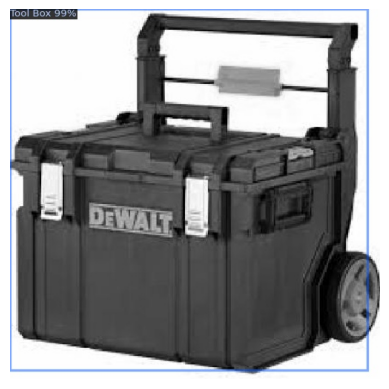

In [40]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Choose an example output image from the results
output_dir = '/content/drive/MyDrive/Data255/Data/models_output_prediction'
example_image = os.path.join(output_dir, os.listdir(output_dir)[0])

# Display the 1st image
image = Image.open(example_image)
plt.imshow(image)
plt.axis('off')
plt.show()
